## Imports

In [263]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [188]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [252]:
def read_data(filename):
    df = pd.read_parquet(filename)
    
    categories_columns = ['PULocationID', 'DOLocationID']
    df[categories_columns] = df[categories_columns].astype('str')
    
    df['duration'] = df['lpep_dropoff_datetime'] -  df['lpep_pickup_datetime']
    
    df['duration'] = (df['duration'].dt.seconds /60).astype('float64').round(4) # duration in minutes
    
    # just o get the same result --> but is probably wrong do this in validation data
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    return df

In [253]:
def select_data(data):
    
    data['PU_DO'] = data['PULocationID'] + '_' +data['DOLocationID']
    
    categories_columns = ['PU_DO']
    #categories_columns = ['PULocationID', 'DOLocationID']
    numerical_columns = ['trip_distance']
    
    dict_data = data[categories_columns + numerical_columns].to_dict(orient='records')
    
    return dict_data

## Train Data

In [254]:
df_train = read_data('../datasets/green_tripdata_2021-01.parquet')

#df_train = df_train.loc[df_train['duration'].between(1,60)]

y_train = df_train['duration']

dict_train = select_data(df_train)
dv = DictVectorizer()
x_train = dv.fit_transform(dict_train)

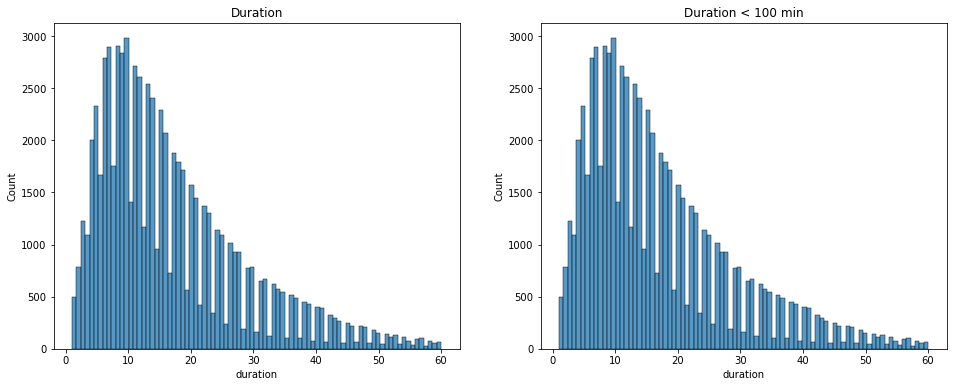

In [255]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(df_train['duration']).set_title('Duration')
plt.subplot(1,2,2)
sns.histplot(df_train.loc[df_train['duration']<100, 'duration']).set_title('Duration < 100 min');

## Validation Data

In [257]:
df_validation = read_data('../datasets/green_tripdata_2021-02.parquet')

y_validation = df_validation['duration']

dict_validation = select_data(df_validation)

x_validation = dv.transform(dict_validation)

## Train and Evaluate Model

### LR MODEL

In [265]:
# define model
lr = LinearRegression()
# train model
lr.fit(x_train, y_train)
# predict on validation
y_predict = lr.predict(x_validation)

In [266]:
y_train_predict = lr.predict(x_train)
mean_squared_error(y_train, y_train_predict, squared=False)

4.640779035632152

In [267]:
print(f'R Mean Squared Errror: {mean_squared_error(y_predict, y_validation, squared=False)}')

print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')

R Mean Squared Errror: 7.4796090491597615
Mean Absolute Percentage Error: 0.3375717826195195


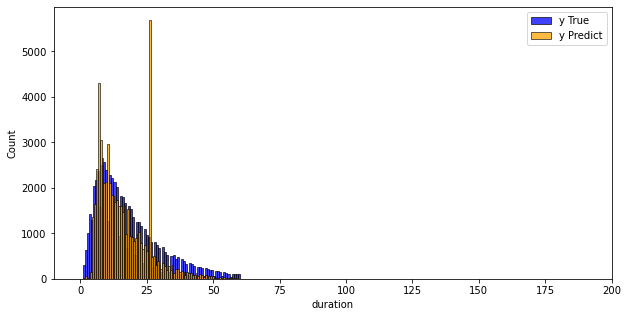

In [268]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Lasso

In [246]:
# define model
lr = Lasso(alpha=0.0001)
# train model
lr.fit(x_train, y_train)
# predict on validation
y_predict = lr.predict(x_validation)

In [247]:
y_train_predict = lr.predict(x_train)
mean_squared_error(y_train, y_train_predict, squared=False)

5.108197780656356

In [248]:
print(f'Mean Squared Errror: {mean_squared_error(y_predict, y_validation, squared=False)}')

print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')

Mean Squared Errror: 7.616617674364716
Mean Absolute Percentage Error: 0.33264342667743946


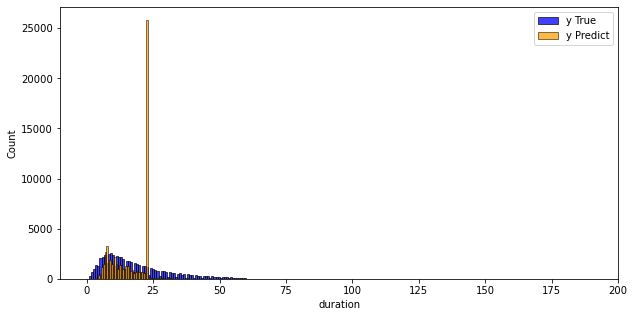

In [227]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Ridge

In [273]:
# define model
lr = Ridge(alpha=0.1)
# train model
lr.fit(x_train, y_train)
# predict on validation
y_predict = lr.predict(x_validation)

In [274]:
y_train_predict = lr.predict(x_train)
mean_squared_error(y_train, y_train_predict, squared=False)

10.71267939576708

In [275]:
print(f'Mean Squared Errror: {mean_squared_error(y_predict, y_validation, squared=False)}')

print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')

Mean Squared Errror: 11.342569061461726
Mean Absolute Percentage Error: 0.6155785329503155


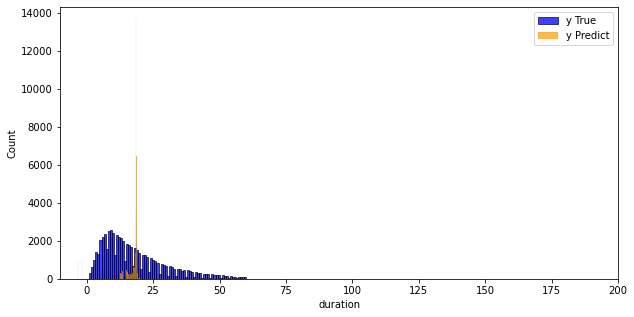

In [276]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Save Model

In [269]:
with open('../models/model.bin', 'wb') as file:
    pickle.dump((dv, lr),file) # for now linear regression